In [ ]:
from google.colab import drive
drive.mount('/gdrive/')
!ls "/gdrive/My Drive/Frame_prediction_kitti/Train_new/"

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).
0000000000.png	0000000091.png	0000000182.png	0000000273.png	0000000364.png
0000000001.png	0000000092.png	0000000183.png	0000000274.png	0000000365.png
0000000002.png	0000000093.png	0000000184.png	0000000275.png	0000000366.png
0000000003.png	0000000094.png	0000000185.png	0000000276.png	0000000367.png
0000000004.png	0000000095.png	0000000186.png	0000000277.png	0000000368.png
0000000005.png	0000000096.png	0000000187.png	0000000278.png	0000000369.png
0000000006.png	0000000097.png	0000000188.png	0000000279.png	0000000370.png
0000000007.png	0000000098.png	0000000189.png	0000000280.png	0000000371.png
0000000008.png	0000000099.png	0000000190.png	0000000281.png	0000000372.png
0000000009.png	0000000100.png	0000000191.png	0000000282.png	0000000373.png
0000000010.png	0000000101.png	0000000192.png	0000000283.png	0000000374.png
0000000011.png	0000000102.png	0000000193.png	0000000284.pn

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import cv2
import tensorflow as tf
from keras.preprocessing import image
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers.core import RepeatVector, Permute
from scipy import ndimage, misc
from keras.optimizers import Adam
from keras.layers import  Flatten,Dense
from keras.initializers import RandomNormal
import random
from keras.layers import Concatenate

from keras.layers import  Flatten,Dense


Using TensorFlow backend.


In [ ]:
#Import the dataset of images into a numpy array.
X = []
names = os.listdir('/gdrive/My Drive/Frame_prediction_kitti/Train_new/')
names.sort()
print(names)
for filename in names:
    #print(filename)
    img = cv2.imread('/gdrive/My Drive/Frame_prediction_kitti/Train_new/'+filename, cv2.IMREAD_UNCHANGED)
    scale_percent = 25 # percent of original size
    width = int(img.shape[1] * (scale_percent-6)/ 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    #print(dim)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
   # plt.imshow(img)
    X.append(resized)
    #plt.show()

X = np.array(X, dtype=float)
print("##################")
# for ele in X:
#   plt.imshow(ele)
#   plt.show()
Xtrain = 1.0/255*X
Xtrain.shape

['0000000000.png', '0000000001.png', '0000000002.png', '0000000003.png', '0000000004.png', '0000000005.png', '0000000006.png', '0000000007.png', '0000000008.png', '0000000009.png', '0000000010.png', '0000000011.png', '0000000012.png', '0000000013.png', '0000000014.png', '0000000015.png', '0000000016.png', '0000000017.png', '0000000018.png', '0000000019.png', '0000000020.png', '0000000021.png', '0000000022.png', '0000000023.png', '0000000024.png', '0000000025.png', '0000000026.png', '0000000027.png', '0000000028.png', '0000000029.png', '0000000030.png', '0000000031.png', '0000000032.png', '0000000033.png', '0000000034.png', '0000000035.png', '0000000036.png', '0000000037.png', '0000000038.png', '0000000039.png', '0000000040.png', '0000000041.png', '0000000042.png', '0000000043.png', '0000000044.png', '0000000045.png', '0000000046.png', '0000000047.png', '0000000048.png', '0000000049.png', '0000000050.png', '0000000051.png', '0000000052.png', '0000000053.png', '0000000054.png', '00000000

(453, 128, 264)

(453, 128, 264, 1)
1.15.2


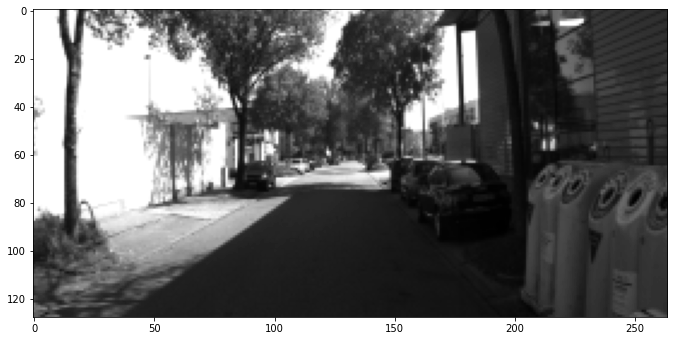

In [ ]:
plt.figure(figsize=[25,25])

plt.subplot(121)
curr_img = np.reshape(Xtrain[0], (128, 264))
#curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
Xtrain= Xtrain.reshape(-1, 128, 264, 1)
print(Xtrain.shape)
print(tf.__version__)

In [ ]:
train_X = Xtrain[:420]
valid_X = Xtrain[420:]
train_ground = Xtrain[:22]
valid_ground = Xtrain[22:]
print(train_X.shape)
print(valid_X.shape)
print(train_ground.shape)
print(valid_ground.shape)

(420, 128, 264, 1)
(33, 128, 264, 1)
(22, 128, 264, 1)
(431, 128, 264, 1)


In [ ]:
batch_size = 1
epochs = 90
inChannel = 1
x, y = 128, 264
input_img = Input(shape = ((x, y, inChannel)))
input_img1 = Input(shape = ((x, y, inChannel)))
input_img2 = Input(shape = ((x, y, inChannel)))
input_img3 = Input(shape = ((x, y, inChannel)))
input_img4 = Input(shape = ((x, y, inChannel)))
decoder_input= Input(shape = ((64,174,256)))

In [ ]:
#define the encoder and decoder network
def encoder(input_img,input_img1,input_img2,input_img3,input_img4):
    init = RandomNormal(stddev=0.02)
    print(input_img)

    merged = Concatenate()([input_img1, input_img2])
    print(merged)
    merged = Concatenate()([merged, input_img3])
    print(merged)
    merged = Concatenate()([merged, input_img4])
    print(merged)
    conv1 = Conv2D(128, (7, 7), activation='relu', padding='same', kernel_initializer=init)(merged) 
    print(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #64 x 132 x 128
    print(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=init)(pool1) 
    print(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #32 x 66 x 128
    print(pool2)
    conv3 = Conv2D(256, (3, 3), activation='tanh', padding='same', kernel_initializer=init)(pool2) #128 x 348 x 256
    print(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #16 x 33 x 256
    print(pool3)
    encoder = Model([input_img1,input_img2,input_img3,input_img4],pool3)
    #encoder.compile(loss='mean_squared_error', optimizer = RMSprop())
    return encoder

def decoder_old(decoder_input):
    init = RandomNormal(stddev=0.02)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=init)(decoder_input) 
    up1 = UpSampling2D((2,2))(conv5) #32 x 66 x 128
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=init)(up1) 
    up2 = UpSampling2D((2,2))(conv6) #64 x 132 x 128
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=init)(up2) 
    up3 = UpSampling2D((2,2))(conv7) # 128 x 264 x 128
    decoded = Conv2D(1, (7, 7), activation='relu', padding='same', kernel_initializer=init)(up3)
    decod = Model(decoder_input, decoded)
    return decod


In [ ]:
print(input_img)
# ec=encoder(input_img)
code = encoder(input_img,input_img1, input_img2,input_img3,input_img4)
code.summary()
decode=decoder_old(decoder_input)
decode.summary()

Tensor("input_1:0", shape=(?, 128, 264, 1), dtype=float32)
Tensor("input_1:0", shape=(?, 128, 264, 1), dtype=float32)
Tensor("concatenate_1/concat:0", shape=(?, 128, 264, 2), dtype=float32)
Tensor("concatenate_2/concat:0", shape=(?, 128, 264, 3), dtype=float32)
Tensor("concatenate_3/concat:0", shape=(?, 128, 264, 4), dtype=float32)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Tensor("conv2d_1/Relu:0", shape=(?, 128, 264, 128), dtype=float32)

Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 64, 132, 128), dtype=float32)
Tensor("conv2d_2/Relu:0", shape=(?, 64, 132, 128), dtype=float32)
Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 32, 66, 128), dtype=float32)
Tensor("conv2d_3/Tanh:0", shape=(?, 32, 66, 256), dtype=float32)
Tensor("max_pooling2d_3/MaxPool:0", shape=(?, 16, 33, 256), dtype=float32)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape

In [ ]:
#Compile the autoencoder
temp=code([input_img1,input_img2,input_img3,input_img4])
dec_output=decode(temp)
auto_encoder=Model([input_img1,input_img2,input_img3,input_img4],dec_output)
opt = Adam(lr=0.0002, beta_1=0.9)
auto_encoder.compile(loss='mean_squared_error', optimizer = opt)

In [ ]:
def concat_input(list_image):
  list_concat=[]
  merged = Concatenate()([list_image[0], list_image[1]])
  merged = Concatenate()([merged, list_image[2]])
  merged = Concatenate()([merged, list_image[3]])
  print(merged.shape)

auto_encoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 264, 1)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 128, 264, 1)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 128, 264, 1)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 128, 264, 1)  0                                            
____________________________________________________________________________________________

In [ ]:
train_x1=Xtrain[:416]
train_x11 = Xtrain[40:356]
train_x2=Xtrain[1:417]
train_x12 = Xtrain[41:357]
train_x3=Xtrain[2:418]
train_x13 = Xtrain[42:358]
train_x4=Xtrain[3:419]
train_x14 = Xtrain[43:359]
y_train=Xtrain[4:420]
y_train1 = Xtrain[44:360]
print(train_x1.shape)

(416, 128, 264, 1)


In [ ]:
#auto_encoder=load_model("/gdrive/My Drive/Frame_prediction_kitti/auto_encoder_input_concat_500ep.h5")
#Train the autoencoder
autoencoder_train = auto_encoder.fit([train_x1,train_x2,train_x3,train_x4], y_train,epochs=1000,verbose=1)


Epoch 1/1000
416/416 [==============================] - 6s 14ms/step - loss: 0.0821
Epoch 2/1000
416/416 [==============================] - 3s 7ms/step - loss: 0.0389
Epoch 3/1000
416/416 [==============================] - 3s 7ms/step - loss: 0.0280
Epoch 4/1000
416/416 [==============================] - 3s 7ms/step - loss: 0.0232
Epoch 5/1000
416/416 [==============================] - 3s 7ms/step - loss: 0.0207
Epoch 6/1000
416/416 [==============================] - 3s 7ms/step - loss: 0.0192
Epoch 7/1000
416/416 [==============================] - 3s 7ms/step - loss: 0.0182
Epoch 8/1000
416/416 [==============================] - 3s 7ms/step - loss: 0.0179
Epoch 9/1000
416/416 [==============================] - 3s 7ms/step - loss: 0.0171
Epoch 10/1000
416/416 [==============================] - 3s 7ms/step - loss: 0.0167
Epoch 11/1000
416/416 [==============================] - 3s 7ms/step - loss: 0.0162
Epoch 12/1000
416/416 [==============================] - 3s 7ms/step - loss: 0.0157

In [ ]:
from skimage.measure import compare_ssim as ssim

#Define the metrics to evaluate performance
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err


def compare_images(imageA, imageB):
	# compute the mean squared error and structural similarity
	# index for the images
	m = mse(imageA, imageB)
	s = ssim(imageA, imageB)
	# setup the figure
	fig = plt.figure()
	plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
	# show first image
	ax = fig.add_subplot(1, 2, 1)
	plt.imshow(imageA, cmap = plt.cm.gray)
	plt.axis("off")
	# show the second image
	ax = fig.add_subplot(1, 2, 2)
	plt.imshow(imageB, cmap = plt.cm.gray)
	plt.axis("off")
	# show the images
	plt.show()

In [ ]:
pred=auto_encoder.predict([train_x1,train_x2,train_x3,train_x4])

In [ ]:
from keras.models import load_model
auto_encoder.save('/gdrive/My Drive/Frame_prediction_kitti/auto_encoder_input_concat_500ep.h5')

In [ ]:
for i in range(0,8):
  print("The input sequence ",i,i+1,i+2,i+3)
  plt.figure(figsize=(100, 100))
  for j in range(i,i+4):
    plt.subplot(2,13,j+1)
    plt.imshow(Xtrain[j,...,0],cmap='gray')
  plt.show()
  print("Predicted Output for the sequence is ")
  plt.figure(figsize=(100, 100))
  plt.subplot(2,13,1)
  plt.imshow(pred[(i),...,0],cmap='gray')
  plt.show()
  print("Original Output for the sequence is ")
  plt.figure(figsize=(100, 100))
  plt.subplot(2,13,1)
  plt.imshow(y_train[(i),...,0],cmap='gray')
  plt.show()

  compare_images(pred[(i),...,0], y_train[(i),...,0])

dict_keys(['loss'])


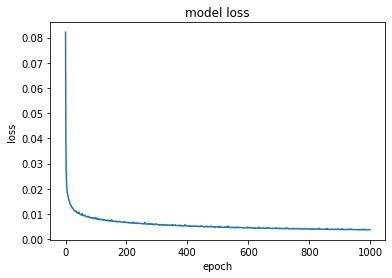

In [ ]:
print(autoencoder_train.history.keys())
# summarize history for loss
plt.plot(autoencoder_train.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print(len(valid_X))
test_x1 = valid_X[:29]
test_x2 = valid_X[1:30]
test_x3 = valid_X[2:31]
test_x4 = valid_X[3:32]
y_test = valid_X[4:33]

33


The input sequence  0 1 2 3


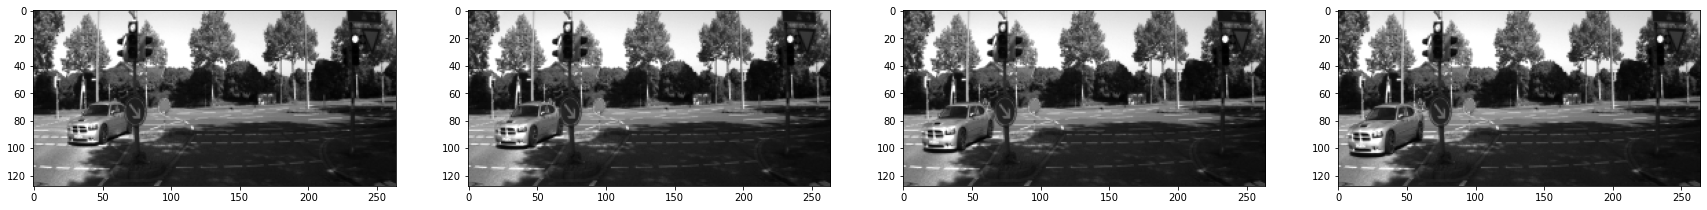

Predicted Output for the sequence is 


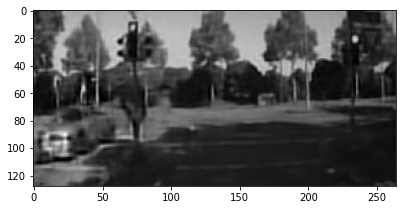

Original Output for the sequence is 


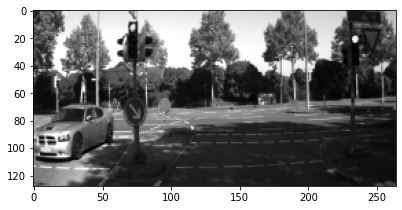

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


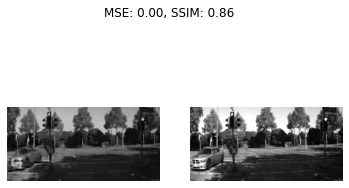

The input sequence  1 2 3 4


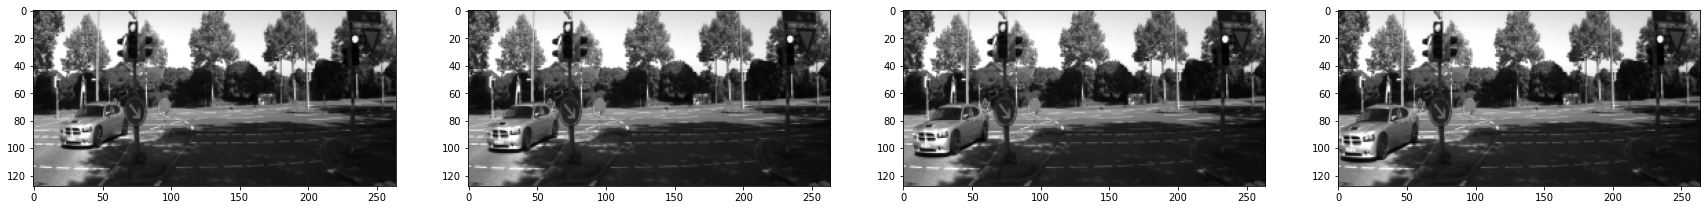

Predicted Output for the sequence is 


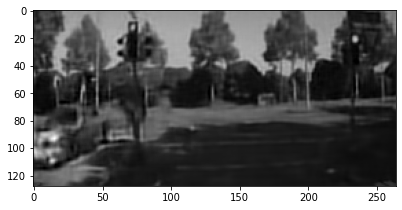

Original Output for the sequence is 


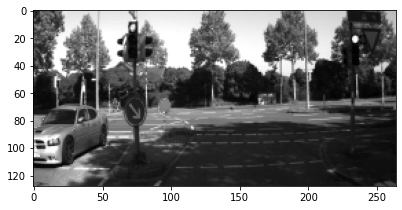

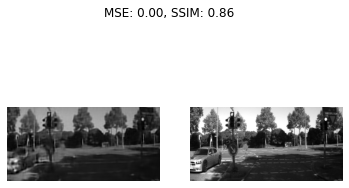

In [ ]:
pred_test = auto_encoder.predict([test_x1, test_x2, test_x3, test_x4])

for i in range(0,2):
  print("The input sequence ",i,i+1,i+2,i+3)
  plt.figure(figsize=(100, 100))
  for j in range(i,i+4):
    plt.subplot(2,13,j+1)
    plt.imshow(valid_X[j,...,0],cmap='gray')
  plt.show()
  print("Predicted Output for the sequence is ")
  plt.figure(figsize=(100, 100))
  plt.subplot(2,13,1)
  plt.imshow(pred_test[(i),...,0],cmap='gray')
  plt.show()
  print("Original Output for the sequence is ")
  plt.figure(figsize=(100, 100))
  plt.subplot(2,13,1)
  plt.imshow(y_test[(i),...,0],cmap='gray')
  plt.show()

  compare_images(pred_test[(i),...,0], y_test[(i),...,0])

In [ ]:
#DESCRIMINATOR 
input_img_disc = Input(shape = (512, 1392, 1))
def discriminator(input_img_disc):
    init = RandomNormal(stddev=0.02)
    conv1 = Conv2D(64, (4, 4),strides=(2,2), activation='relu', padding='same',kernel_initializer=init)(input_img_disc) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #256 x 696 x 64
    conv2 = Conv2D(128, (4, 4),strides=(2,2), activation='relu', padding='same',kernel_initializer=init)(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #128 x 348 x 128
    conv3 = Conv2D(256, (4, 4),strides=(2,2), activation='relu', padding='same',kernel_initializer=init)(pool2) #128 x 348 x 256
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #64 x 174 x 256
   #conv4=Conv2D(512,(4,4),activation='relu',padding='same')(pool3)
    #pool4=MaxPooling2D(pool_size=(2,2))(conv4) # 32 x 87 x 128
    conv5=Conv2D(4,(1,1),activation='relu',padding='same',kernel_initializer=init)(pool3)
    flat=Flatten()(conv5)
    #fake_real = Dense(100, activation='relu',kernel_initializer=init)(flat)
    fake_real2 = Dense(1, activation='sigmoid',kernel_initializer=init)(flat)
    return fake_real2
def call_disc(input_img_disc):
  discriminato = Model(input_img_disc, discriminator(input_img_disc))
  opt = Adam(lr=0.0002, beta_1=0.9)
  discriminato.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  #discriminator.summary()
  return discriminato

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, input_img1,input_img2,input_img3,input_img4):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	#in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model([input_img1,input_img2,input_img3,input_img4])
	# connect the source input and generator output to the discriminator input
	dis_out = d_model(gen_out)
	# src image as input, generated image and classification output
	# model = Model(in_src, dis_out)
	# # compile model
	# opt = Adam(lr=0.02, beta_1=0.05)
	# model.compile(loss='binary_crossentropy', optimizer=opt)
	return dis_out

def call_gan(g_model,d_model,input_img1,input_img2,input_img3,input_img4):
  model=Model([input_img1,input_img2,input_img3,input_img4],define_gan(g_model,d_model,input_img1,input_img2,input_img3,input_img4))
  opt = Adam(lr=0.0002, beta_1=0.9)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model  

In [ ]:

def generate_real_samples(Xtrain,number, batch_size):
  list_real_sample = []
  for i in range(number,number+batch_size):
    list_real_sample.append(Xtrain[i])
  real_sample=np.asarray(list_real_sample)
  li=[.95]*len(real_sample)
  y=np.asarray(li)
  #y = np.ones(len(real_sample))
  return real_sample, y


def generate_fake_samples(g_model, Xtrain,number,batch_size):
  z1=Xtrain[number:number+batch_size]
  z2=Xtrain[number+1:number+batch_size+1]
  z3=Xtrain[number+2:number+batch_size+2]
  z4=Xtrain[number+3:number+batch_size+3]
  final_pred = g_model.predict([z1,z2,z3,z4])
  print("Predicted Output for the sequence is ")
  # for i in range(0,4):
  #   plt.figure(figsize=(100, 100))
  #   plt.subplot(2,13,1)
  #   plt.imshow(final_pred[(i),...,0],cmap='gray')
  #   plt.show()
  li=[.05]*len(final_pred)
  y=np.asarray(li)
  #y = np.zeros(len(final_pred))
  return final_pred, y

In [ ]:
#Train the GAN Model
def train(g_model, d_model, gan_model, Xtrain, n_epochs=100, n_batch=4):
  bat_per_epo = int(len(Xtrain)/ n_batch)
  half_batch = int(n_batch / 2)
	# manually enumerate epochs
  for i in range(n_epochs):
		# enumerate batches over the training set
    print("EPOCH NUMBER ",i)
    for j in range(bat_per_epo):
      number=random.randint(0,20)
      number2=random.randint(0,20)
      print(number)
			# get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(Xtrain,number+4, n_batch)
      X_real2, y_real2 = generate_real_samples(Xtrain,number2+4, n_batch)
      #print(X_real.shape,y_real.shape)
			# update discriminator model weights
      d_loss1, _ = d_model.train_on_batch(X_real,y_real)
      d_loss11, _ = d_model.train_on_batch(X_real2,y_real2)
      print("D_loss1:",d_loss1)
     # print("D_loss11:",d_loss11)
      print("Discriminator prediction for real images ",d_model.predict(X_real))
			# generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, Xtrain,number, n_batch)
      X_fake2, y_fake2 = generate_fake_samples(g_model, Xtrain,number2, n_batch)
			# update discriminator model weights
      for k in range(0,4):
        plt.figure(figsize=(100, 100))
        plt.subplot(2,13,1)
        plt.imshow(X_fake[(k),...,0],cmap='gray')
        plt.show()
      d_loss_fake2,_ = d_model.train_on_batch(X_fake, y_fake)
      d_loss_fake22,_ = d_model.train_on_batch(X_fake2, y_fake2)
      print("D_loss_fake1:",d_loss_fake2)
      print("D_loss_fake11:",d_loss_fake22)
      print("Dicriminator prediction for fake images ",d_model.predict(X_fake))
			# create inverted labels for the fake samples
      li=[.95]*(n_batch)
      y_gan=np.asarray(li)
      #y_gan = np.ones(n_batch)
			# update the generator via the discriminator's error
      z1=Xtrain[number:number+n_batch]
      z2=Xtrain[number+1:number+n_batch+1]
      z3=Xtrain[number+2:number+n_batch+2]
      z4=Xtrain[number+3:number+n_batch+3]
      #print(z1.shape)
      g_loss = gan_model.train_on_batch([z1,z2,z3,z4], y_gan)
      print("PRediction for GAN predictions of fake images are ",gan_model.predict([z1,z2,z3,z4]))
      # if(g_loss>0.5):
      g_loss2 = g_model.train_on_batch([z1,z2,z3,z4],X_real)
      print("G_LOSS2 ",g_loss2)
      print("G_loss:",g_loss)
			# summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss_fake2, g_loss))
	# save the generator model
	#g_model.save('cgan_generator.h5')
  return d_model,g_model,gan_model

In [ ]:

in_src = Input(shape = ((64, 174, 1024)))
#gan_model=define_gan(gen(input_concatenated),call_disc(input_img_disc),input_concatenated)
discriminator,generator,gan_model=train(auto_encoder,call_disc(input_img_disc),call_gan(auto_encoder,call_disc(input_img_disc),input_img1,input_img2,input_img3,input_img4),Xtrain)

In [ ]:
pred =generator.predict([train_x1,train_x2,train_x3,train_x4])